In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
np.random.seed(42)

### Dot product with Guassian is 2-stable

It turns out that the standard normal distribution is 2-stable [5]. And by that we mean it satisfies the property that for any $d$ dimensional vector $v \in \mathbb{R}^d$, and an equally dimensional guassian iid sampled $x_i \sim \mathcal{Z}$, then the dot product is distributed $\langle{v}, {x}\rangle \sim \|v\|_2\mathcal{Z}$. That is, a normal distribution that has been stretched out by the magnitude of the the vector $v$. Notice too that 

First we prove it, and then we'll test it experimentally. Here's a hand-wavy proof, but also see [1] [2] [3] [4]:

> The dot product $\langle{v}, {x}\rangle$ is $\sum_i v_i x_i$. Each $v_i x_i \sim \mathcal{N}(0, v_i^2)$. And by the linearity of gaussians $\sum \mathcal{N}(0, v_i^2) = \mathcal{N}(0, \sum v_i^2) = \mathcal{N}(0, \|v\|_2) = \|v\|_2\mathcal{Z}$.


References:
- [1] https://math.stackexchange.com/a/275668
- [2] https://www.projectrhea.org/rhea/index.php/Linear_combinations_of_independent_gaussian_RVs
- [3] https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables
- [4] https://cseweb.ucsd.edu/~dasgupta/254-embeddings/lawrence.pdf
- [5] https://graphics.stanford.edu/courses/cs468-06-fall/Papers/12%20lsh04.pdf

Check it out, we can witness the effect of scale on a normal variable by multiplying it by some factor $c$. But note that from [1], analogously from this graph we can't assume it's from the same distribution. And it additionally turns out that $c \mathcal{N} \sim \mathcal{N}$.

Text(0, 0.5, 'std')

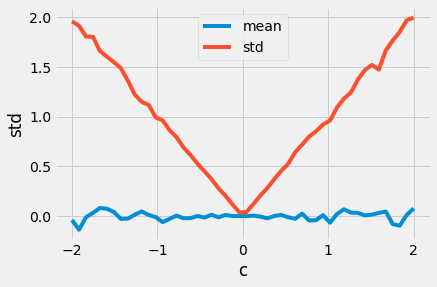

In [4]:
cs = np.linspace(-2, 2)
ms, vs = [], []
for c in cs:
    desc = stats.stats.describe(c*stats.norm.rvs(size=10**3))
    ms.append(desc.mean)
    vs.append(desc.variance**0.5)
plt.plot(cs, ms, label='mean')
plt.plot(cs, vs, label='std')
plt.legend()
plt.xlabel("c")
plt.ylabel("std")

Ok, now let's empirically see that the dot products are distributed $\langle{v}, {x}\rangle \mathcal \sim \|v\|{Z} = \mathcal{N}(0, \|v\|_2^2)$. While yes, we have proved it, playing with it manually can prove to reveal some interesting perspectives and insight.

How do we empirically show that? We'll sample a bunch of vectors $v$, and a bunch of vectors $x$, take their dot products and see what the distribution looks like. We can then make assertions based on that sample. In particular that it's normal, and is distributed $\|v\|_2\mathcal{Z}$.

But there's some subtlety here. Suppose we sample $x \sim \mathcal{Z}$ and $v \sim \mathcal{V}$, then from the theorem we would expect an emperical sample of these to be distributed $\mathcal{N}(0, \mathbb{E}[\mathcal{V}]))$, where $\|v\| \sim \mathcal{M}$ and $v \sim \mathcal{V}$.

Let's naively say that we do $v \in \mathrm{Uniform}$. What do we expect the distribution of $\|v\| \sim \mathcal{M}$ to then be? This turns out to be pretty freakin' weird. Please, if you would allow the disgression, I promise it's fun: $\mathcal{M}$ is like the uniform sum distribution [1] [2], but not quite.

- [1] https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution
- [2] http://mathworld.wolfram.com/UniformSumDistribution.html

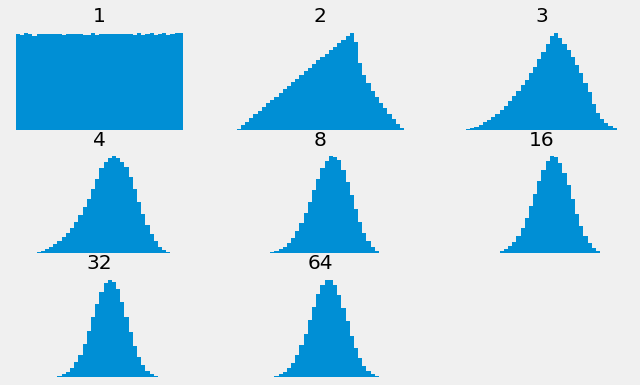

In [5]:
n = 10**6  # number of samples
plt.figure(figsize=(10, 6))
for i, d in enumerate([1, 2, 3, 4, 8, 16, 32, 64]):
    d = int(d)
    plt.subplot(3, 3, i+1)
    xs = stats.uniform.rvs(size=(n, d))
    norms = np.linalg.norm(xs, axis=1)
    plt.title(d)
    plt.hist(norms, bins=40);
    plt.xticks([])
    plt.yticks([])

That looks like a normal distribution, after enough.

CPU times: user 22.6 s, sys: 12.2 s, total: 34.8 s
Wall time: 34.6 s


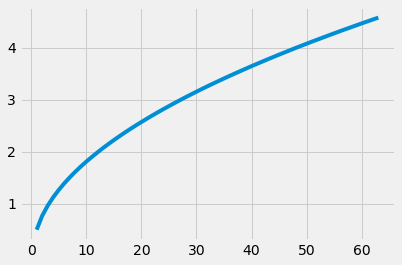

In [6]:
%%time
n = 10**6
d = 8

mus, stds = [], []
ds = np.arange(1, 64)
for d in ds:
    xs = stats.uniform.rvs(size=(n, d))
    norms = np.linalg.norm(xs, axis=1)
    mu, std = stats.norm.fit(norms)
    mus.append(mu)
    stds.append(std)

plt.plot(ds, mus)

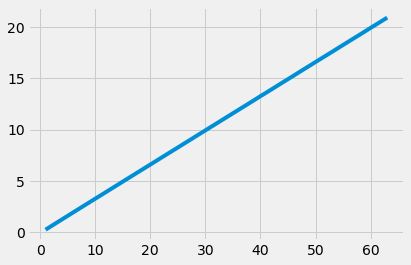

In [7]:
plt.plot(ds, [x**2 for x in mus])

In [8]:
stats.linregress(ds, [x**2 for x in mus])

LinregressResult(slope=0.33343296178674137, intercept=-0.07208151937286189, rvalue=0.9999998750381593, pvalue=4.3713998823028023e-203, stderr=2.1342601620864038e-05)

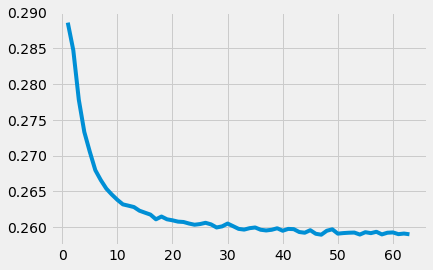

In [9]:
plt.plot(ds, stds)

So it looks like $\|v\| \sim \mathcal{N(\sqrt{d/3}, 0.25)}$ as $d \to \infty$. Weird. That mysterious plot feels like a log curve without a converging asymptote, but who knows. Might be gnarly.

Let's fix some v, and show that it's std. dev. is equal to it's norm.

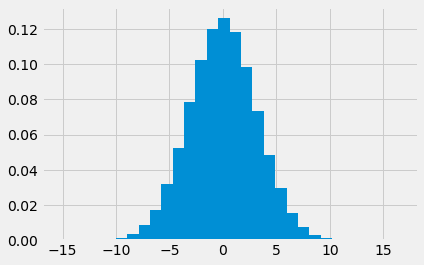

In [10]:
n = 10**6
d = 32

res = []              # sample of dot products
fx = stats.norm       # dist to sample x from
v = np.random.rand(d)
x = fx.rvs(size=(n, d))
res2 = x.dot(v)
plt.hist(res2, bins=30, density=True);

In [11]:
stats.norm.fit(res2)

(0.0020324817286705614, 3.1468157850740375)

In [12]:
np.linalg.norm(v)

3.149289063503838

Now pick a bunch of $v$ and $x$ separately, and we expect $v \sim \mathcal{M}$. Where from above experiments, $\mathbb{E}[\|v\|_2] \approx \sqrt{d/3}$.

In [13]:
np.sqrt(32/3)

3.265986323710904

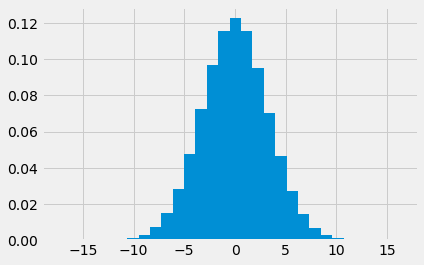

In [14]:
n = 10**6
d = 32

res = []              # sample of dot products
fv = stats.uniform    # dist to sample v from
fx = stats.norm       # dist to sample x from
v = fv.rvs(size=(n, d))
x = fx.rvs(size=(n, d))
res = np.einsum('ij,ij->i', v, x)  # row-wise dot-product
plt.hist(res, bins=30, density=True);

In [15]:
print(stats.normaltest(res))  # K^2 normal test
stats.norm.fit(res)           # MLE

NormaltestResult(statistic=181.71773196616223, pvalue=3.4713297599728165e-40)


(-0.002855097864818624, 3.2642746308182966)

Our MLE std should be close to our sample std, since $\langle{v}, {x}\rangle \sim \|v\|_2Z$.

In [16]:
v.shape, np.linalg.norm(v, axis=1).shape

((1000000, 32), (1000000,))

In [17]:
exp_norm = np.linalg.norm(v, axis=1).mean()
exp_norm

3.2554087666728795

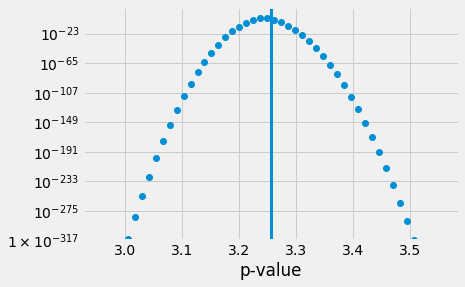

In [18]:
ps = []
w = 0.3
scales = np.linspace(exp_norm - w, exp_norm + w)
for scale in scales:
    ts = stats.kstest(res, stats.norm(loc=0, scale=scale).cdf)
    ps.append(ts.pvalue)
plt.semilogy(scales, ps, 'o')
plt.axvline(exp_norm, lw=3)
plt.xlabel('p-value');

In [19]:
stats.kstest(res, stats.norm(loc=0, scale=exp_norm).cdf).pvalue

0.009970609764874246

I suppose I would have expected a larger p-value. But yeah, the theorem is empirically validated.

### Probability of collision

The probability of collision is that of when their absolute value is within some range, and they don't cross boundaries.